In [1]:
from mma import *
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from multipers import *
from joblib import Parallel, delayed
from multiprocessing import Pool, Manager, cpu_count
from sklearn.neighbors import KernelDensity
from joblib import parallel_backend
from numpy.polynomial.polynomial import polyfit
from benchmark_functions import *
from tqdm import tqdm

### Parameters

In [2]:
size = 100
min_npts = 5
max_npts = 200
f_outliers = 0.02
nlines = 100

In [3]:

time_s = []
# std_s = []
nsimplices_s = []
time_na = []
# std_na = []
nsimplices_na = []
box = [[0,0], [2,2]]
precision = 4 / nlines
set_of_npts = np.linspace(start=20, stop=1000, num = size).astype(int)
for i in tqdm(range(size)):
    ## Generate synthetic point clouds
    npts = set_of_npts[-i-1]
    X = np.random.uniform(low=0, high=1, size = (npts,2))
    Y = np.array(noisy_annulus(1,1.4, (int)(npts*(1-f_outliers)))
                 + noisy_annulus(0,0.8,(int)(npts*f_outliers/2)) 
                 + noisy_annulus(1.5,4,(int)(npts*f_outliers/2)))
    ## Compute Rips and give number of simplices
    square_st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=2)
    nsimplices_s.append(square_st.num_simplices())
    na_st     = gd.AlphaComplex(points=Y).create_simplex_tree(max_alpha_square=2)
    nsimplices_na.append(na_st.num_simplices())
    
#     print(i, square_st.num_simplices(),na_st.num_simplices(), flush=1)

    # Random filters for square
    filters = [np.random.uniform(low = 0, high = 1, size =[npts,1]) for _ in range(2)]
    # Density + Rips for annulus 
    kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(Y)
    density = -np.array(kde.score_samples(Y))
    complex_filtration = [na_st.filtration(simplex[0]) for simplex in na_st.get_simplices()]
    
    t = time_approx(square_st, filters, precision, box)
    time_s.append(t)
    
    boundary, filters = ls_boundary_density(na_st,[complex_filtration, density], to_permute = [0])
    t = time_approx(boundary, filters, precision, box)
    time_na.append(t)

100%|█████████████████████████████████████████| 100/100 [02:58<00:00,  1.78s/it]


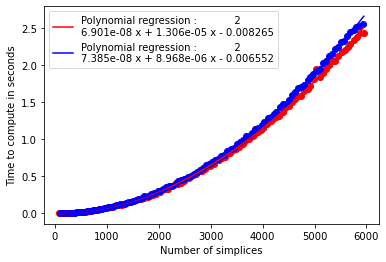

In [4]:
## scatter points
plt.scatter(nsimplices_na, time_na, c='r')
plt.scatter(nsimplices_s, time_s, c='b')

## polynomial regressions 
x = np.linspace(start = min(nsimplices_na), stop = max(nsimplices_na), num =100)

poly_na = np.poly1d(np.polyfit(nsimplices_na, time_na,2))
plt.plot(x, poly_na(x), label="Polynomial regression : {}".format(poly_na), c='r')

poly_na = np.poly1d(np.polyfit(nsimplices_s, time_s,2))
plt.plot(x, poly_na(x), label="Polynomial regression : {}".format(poly_na), c='b')

## Labels
plt.legend()
plt.xlabel("Number of simplices")
plt.ylabel("Time to compute in seconds")
plt.savefig("time_vs_simplices_" + str(nlines) + "nlines.svg")
plt.show()

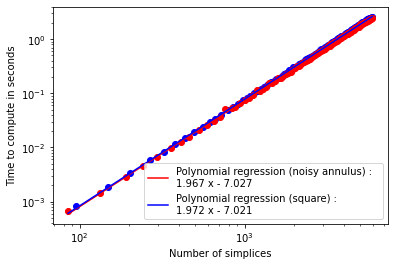

In [5]:
fig, ax = plt.subplots()
plt.scatter(nsimplices_s,time_s, c='b')
plt.scatter(nsimplices_na,time_na, c='r')

poly_na_log = np.poly1d(np.polyfit(np.log10(nsimplices_na), np.log10(time_na),1))
yfit_na = lambda x: np.power(10,poly_na_log(np.log10(x)))
plt.plot(x, yfit_na(x), label="Polynomial regression (noisy annulus) : {}".format(poly_na_log), c='r')

poly_s_log = np.poly1d(np.polyfit(np.log10(nsimplices_s), np.log10(time_s),1))
yfit_s = lambda x: np.power(10,poly_s_log(np.log10(x)))
plt.plot(x,yfit_s(x), label="Polynomial regression (square) : {}".format(poly_s_log), c='b')
ax.set_xscale("log");
ax.set_yscale("log");
plt.legend()
plt.xlabel("Number of simplices")
plt.ylabel("Time to compute in seconds")
plt.savefig("loglog_time_vs_simplices_" + str(nlines) + "nlines.svg")
plt.show()

### complexity wrt the number of lines

In [6]:
npts = 200
time_s = []
# std_s = []
nsimplices_s = []
time_na = []
# std_na = []
nsimplices_na = []
box = [[0,0], [2,2]]

set_of_nlines = np.linspace(start=20, stop=1000, num = size).astype(int)
for i in tqdm(range(size)):
    ## Generate synthetic point clouds
    X = np.random.uniform(low=0, high=1, size = (npts,2))
    Y = np.array(noisy_annulus(1,1.4, (int)(npts*(1-f_outliers)))
                 + noisy_annulus(0,0.8,(int)(npts*f_outliers/2)) 
                 + noisy_annulus(1.5,4,(int)(npts*f_outliers/2)))
    nlines = set_of_nlines[-i-1]
    precision = 4 / nlines
    
    ## Compute Rips and give number of simplices
    square_st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=2)
#     nsimplices_s.append(square_st.num_simplices())
    na_st     = gd.AlphaComplex(points=Y).create_simplex_tree(max_alpha_square=2)
#     nsimplices_na.append(na_st.num_simplices())
    
#     print(i, square_st.num_simplices(),na_st.num_simplices(), flush=1)

    # Random filters for square
    filters = [np.random.uniform(low = 0, high = 1, size =[npts,1]) for _ in range(2)]
    # Density + Rips for annulus 
    kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(Y)
    density = -np.array(kde.score_samples(Y))
    complex_filtration = [na_st.filtration(simplex[0]) for simplex in na_st.get_simplices()]
    
    t = time_approx(square_st, filters, precision, box)
    time_s.insert(0,t)
    
    boundary, filters = ls_boundary_density(na_st,[complex_filtration, density], to_permute = [0])
    t = time_approx(boundary, filters, precision, box)
    time_na.insert(0,t)

100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


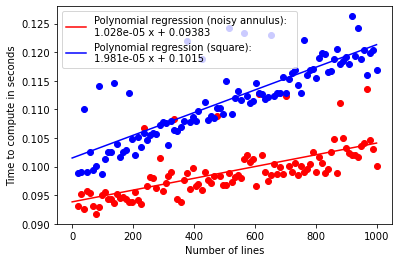

In [7]:
x = [0,1000]
plt.scatter(set_of_nlines, time_na, c='r')
poly_na = np.poly1d(np.polyfit(set_of_nlines, time_na,1))
plt.plot(x, poly_na(x), label="Polynomial regression (noisy annulus): {}".format(poly_na), c='r')

plt.scatter(set_of_nlines, time_s, c='b')
poly_s = np.poly1d(np.polyfit(set_of_nlines, time_s,1))
plt.plot(x, poly_s(x), label="Polynomial regression (square): {}".format(poly_s), c='b')
plt.xlabel("Number of lines")
plt.ylabel("Time to compute in seconds")
plt.legend(loc=2)
plt.savefig("time_vs_lines_" + str(npts) + "npts.svg")
plt.show()